实际业务中，我们需要处理的图往往很大，可能会有上亿的节点和边，如果把这些数据进行全量训练，GPU显存很难放的下，所以我们需要使用类似于DNN中那样的随机批量学习的方式进行训练，与DNN中的批量学习不同，GNN对单个训练样本的训练还需要利用到它的邻居节点，而且每多增加一层网络，所需的邻居样本还要往外扩展一层，所以对于$k$层的GNN网络，我们需要对训练样本进行$k$阶的子图采样操作（回想一下之前GraphSAGE代码中采样...），借助于DGL的api，我们只需要多添加2行代码就可以了...

In [1]:
#1.准备数据
import numpy as np
import torch
import dgl
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import HeteroGraphConv, GraphConv

n_users = 1000
n_items = 500
n_follows = 3000
n_clicks = 5000
n_dislikes = 500
n_hetero_features = 10
n_user_classes = 5
n_max_clicks = 10

follow_src = np.random.randint(0, n_users, n_follows)
follow_dst = np.random.randint(0, n_users, n_follows)
click_src = np.random.randint(0, n_users, n_clicks)
click_dst = np.random.randint(0, n_items, n_clicks)
dislike_src = np.random.randint(0, n_users, n_dislikes)
dislike_dst = np.random.randint(0, n_items, n_dislikes)

hetero_graph = dgl.heterograph({
    ('user', 'follow', 'user'): (follow_src, follow_dst),
    ('user', 'followed-by', 'user'): (follow_dst, follow_src),
    ('user', 'click', 'item'): (click_src, click_dst),
    ('item', 'clicked-by', 'user'): (click_dst, click_src),
    ('user', 'dislike', 'item'): (dislike_src, dislike_dst),
    ('item', 'disliked-by', 'user'): (dislike_dst, dislike_src)})

hetero_graph.nodes['user'].data['feature'] = torch.randn(n_users, n_hetero_features)
hetero_graph.nodes['item'].data['feature'] = torch.randn(n_items, n_hetero_features)
hetero_graph.nodes['user'].data['label'] = torch.randint(0, n_user_classes, (n_users,))
hetero_graph.edges['click'].data['label'] = torch.randint(1, n_max_clicks, (n_clicks,)).float()
# 在user类型的节点和click类型的边上随机生成训练集的掩码
hetero_graph.nodes['user'].data['train_mask'] = torch.zeros(n_users, dtype=torch.bool).bernoulli(0.6)
hetero_graph.edges['click'].data['train_mask'] = torch.zeros(n_clicks, dtype=torch.bool).bernoulli(0.6)

user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
labels = hetero_graph.nodes['user'].data['label']
train_mask = hetero_graph.nodes['user'].data['train_mask']
train_idx = torch.nonzero(train_mask, as_tuple=False).squeeze()

Using backend: pytorch


我们使用`MultiLayerFullNeighborSampler`进行采样，它会采样当前节点的所有邻居节点，利用`NodeDataLoader`进行数据的批量读取

In [2]:
#2.定义采样器
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)#采样2阶子图，对应了GNN中2层网络

In [3]:
dataloader = dgl.dataloading.NodeDataLoader(hetero_graph, {"user": train_idx}, sampler, batch_size=128, shuffle=True,num_workers=0)

通过对dataloader迭代，我们每次可以取出input_nodes, output_nodes, blocks这三个变量，其中：     
**input_nodes**：包括训练所需的所有节点ID   
**output_nodes**：包括训练目标的节点，对应上面128个随机的user节点  
**blocks**：是个list,从blocks[0],blocks[1]....分别对应了节点的$k$阶子图，$k-1$阶子图.....直到这128个user节点自身的$0$阶子图

In [4]:
input_nodes, output_nodes, blocks = next(iter(dataloader))

由于将原始的大图切分为了一个一个的block，所以对于模型定义中的`forward`阶段需要做一点修改，改动也很简单，将原始的全图变量，依层替换为对应的block即可

In [5]:
#3.定义模型
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        # 实例化HeteroGraphConv，in_feats是输入特征的维度，out_feats是输出特征的维度，aggregate是聚合函数的类型
        self.conv1 = HeteroGraphConv({
            rel: GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = HeteroGraphConv({
            rel: GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, blocks, inputs):
        # 输入是节点的特征字典
        h = self.conv1(blocks[0], inputs)#2阶子图
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(blocks[1], h)#1阶子图
        return h

In [6]:
#4.训练模型
#训练阶段没太大差异，注意输入、输出的具体格式
losses=[]
model = RGCN(n_hetero_features, 20, n_user_classes, hetero_graph.etypes)
opt = torch.optim.Adam(model.parameters(),lr=1e-2)
if __name__ == '__main__':
    model.train()
    for _ in range(20):
        for input_nodes, output_nodes, blocks in dataloader:
            # blocks = [b.to(torch.device('cuda')) for b in blocks]
            input_features = blocks[0].srcdata['feature']  # returns a dict
            output_labels = blocks[-1].dstdata['label']  # returns a dict
            output_predictions = model(blocks, input_features)
            loss = F.cross_entropy(output_predictions['user'], output_labels['user'])
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

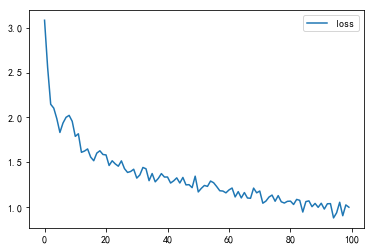

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)
plt.legend(["loss"])